# Шаг 1 - исследование данных и предобработка
https://colab.research.google.com/drive/1aQGiPgbnjoox2iKtwOFf3F3o7z-W-9L5?usp=sharing

### Импорт датасета и либ

In [1]:
import seaborn as sns
import pandas as pd
import numpy as np


df = pd.read_csv('data_1.csv', delimiter=';')
df.head()

,Год,Время года,Климат,Город,Страна,Способ охлаждения,Режим при смешанном типе охлаждения,Способ обогрева,Возраст,Пол,...,Скорость воздуха,Рост,Вес,Занавески,Вентилятор,Окно,Двери,Отопление,Среднемесячная температура на улице,Количество рекламаций
0,2011.0,Лето,Cубтропический океанический,Техас,США,Кондиционирование,NaN,NaN,22.0,NaN,...,0.26,NaN,NaN,1.0,1.0,NaN,NaN,NaN,28.9,0
1,2011.0,Лето,Cубтропический океанический,Техас,США,Кондиционирование,NaN,NaN,40.0,NaN,...,0.12,NaN,NaN,0.0,0.0,NaN,NaN,NaN,84.0,0
2,2011.0,Лето,Cубтропический океанический,Техас,США,Кондиционирование,NaN,NaN,42.0,NaN,...,0.08,NaN,NaN,0.0,0.0,NaN,NaN,NaN,32.8,0
3,2011.0,Лето,Cубтропический океанический,Техас,США,Кондиционирование,NaN,NaN,27.0,NaN,...,27.16,NaN,NaN,1.0,1.0,NaN,NaN,NaN,28.9,1
4,2011.0,Лето,Cубтропический океанический,Техас,США,Кондиционирование,NaN,NaN,46.0,NaN,...,63.83,NaN,NaN,1.0,1.0,NaN,NaN,NaN,32.8,0


### Функции для отчитски и подготовки датасета

* Приведение к PEP8

In [2]:
def to_pep_8():
    df.columns = df.columns.str.lower().str.replace(' ', '_')

* Смещение категориальных `NaN` к [-1, 0, 1] & приведение к целичисленному

In [3]:
# К нужному типу данных (+ nan для категорий -1 0 1)
def dtype_to_int(cols: list):
    for col in cols:
        df[col] = df[col].astype(int)

        
def fill_nan_category(cols: list):
    for col in cols:  # repl (0, -1) (nan, 0) to int
        df[col] = df[col].replace(0., -1.)
        df[col] = df[col].fillna(0.)

* Корректировка строковых значений с ошибками

In [4]:
# Correction values
def data_correction(): 
    replace_climat = {"Cубтроп океанич": "Cубтропический океанический"}
    replace_delta_temp = {"Холодн": "Холоднее", "Тепле": "Теплее"}
    
    df["климат"] = df["климат"].transform(
        lambda x: replace_climat[x] if x in replace_climat else x)
    df["предпочтительное_изменение_температуры"] = df["предпочтительное_изменение_температуры"].transform(
        lambda x: replace_delta_temp[x] if x in replace_delta_temp else x)

* 1) Замена `NaN` медианой, затем земена выбросов медианой
* 2) Медиана доступна по подгруппам
* 3) Доступны фиксированные значения лимитов

In [5]:
# Fill nan and outliers
def fill_nan_group_median(column: str, group_col: list, custom_high_limit=None, custom_low_limit=None):
    if len(group_col) > 0:
        df[column] = (df.groupby(group_col, sort=False, dropna=False)[column].transform(
            lambda elem: elem.fillna(elem.median() if elem.median() == np.nan else df[column].median())))
        # df[column] = df[column].fillna(df.groupby(group_col, dropna=False)[column].transform('median'))
    else:
        df[column] = df[column].fillna(df[column].median())
    
    
def fill_3iqr_outliers(column: str):
    Q1, Q3 = np.nanpercentile(df[column], [25, 75])
    IQR  = Q3 - Q1
    High = Q3 + 3 * IQR
    Low  = Q1 - 3 * IQR
    df[column] = df[column].where(df[column].between(Low, High), np.nan)
    
    
def fill_outliers_hard(column: str, high=None, low=None):
    df[column] = df[column].where(
        df[column].between(
            low if low else -np.inf,
            high if high else np.inf),
        np.nan)

### Быстрый анализ

In [38]:
# Однозначно необходимо
to_pep_8()
data_correction()
print(list(df.columns))

['год', 'время_года', 'климат', 'город', 'страна', 'способ_охлаждения', 'режим_при_смешанном_типе_охлаждения', 'способ_обогрева', 'возраст', 'пол', 'ощущение_температуры', 'ощущение_температуры_(bool)', 'предпочтительное_изменение_температуры', 'ощущение_движения_воздуха_(bool)', 'предпочтительное_изменение_движения_воздуха', 'оценка_комфорта', 'утепление', 'температура_воздуха_в_помещении', 'температура_воздуха_на_улице', 'rh', 'скорость_воздуха', 'рост', 'вес', 'занавески', 'вентилятор', 'окно', 'двери', 'отопление', 'среднемесячная_температура_на_улице', 'количество_рекламаций']


In [8]:
# df.where(df["среднемесячная_температура_на_улице"] > 45).dropna(axis=0, how='all')
df.where(df["страна"] == "Индия").dropna(axis=0, how='all')["утепление"].describe()

count    214.000000
mean       0.803692
std        0.288351
min        0.460000
25%        0.652500
50%        0.705000
75%        0.840000
max        2.080000
Name: утепление, dtype: float64

In [9]:
df.groupby(["страна"])["утепление"].describe()

,count,mean,std,min,25%,50%,75%,max
страна,,,,,,,,
Австралия,198.0,0.468232,0.082802,0.36,0.4100,0.460,0.4975,0.86
Индия,214.0,0.803692,0.288351,0.46,0.6525,0.705,0.8400,2.08
США,72.0,0.589444,0.043602,0.54,0.5700,0.570,0.6100,0.79


In [42]:
for val in df.groupby(["страна", "время_года"])["утепление"]:
    print(val[0], sorted(val[1]), val[1].describe())

('Австралия', 'Лето') [0.36, 0.36, 0.37, 0.37, 0.37, 0.37, 0.37, 0.37, 0.38, 0.38, 0.38, 0.38, 0.39, 0.39, 0.39, 0.39, 0.39, 0.39, 0.39, 0.39, 0.39, 0.39, 0.39, 0.39, 0.39, 0.39, 0.39, 0.39, 0.39, 0.39, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.41, 0.41, 0.41, 0.41, 0.41, 0.41, 0.41, 0.41, 0.41, 0.41, 0.41, 0.41, 0.41, 0.41, 0.41, 0.41, 0.41, 0.41, 0.42, 0.42, 0.42, 0.42, 0.42, 0.42, 0.42, 0.43, 0.43, 0.43, 0.43, 0.43, 0.43, 0.43, 0.43, 0.43, 0.43, 0.43, 0.43, 0.43, 0.43, 0.43, 0.43, 0.43, 0.44, 0.44, 0.44, 0.45, 0.46, 0.46, 0.46, 0.46, 0.46, 0.46, 0.46, 0.46, 0.46, 0.46, 0.46, 0.46, 0.46, 0.46, 0.46, 0.46, 0.46, 0.46, 0.46, 0.46, 0.46, 0.46, 0.46, 0.46, 0.46, 0.46, 0.46, 0.46, 0.46, 0.46, 0.46, 0.46, 0.46, 0.46, 0.46, 0.46, 0.46, 0.46, 0.46, 0.46, 0.46, 0.46, 0.46, 0.46, 0.46, 0.46, 0.46, 0.46, 0.46, 0.46, 0.46, 0.46, 0.46, 0.46, 0.46, 0.46, 0.46, 0.46, 0.46, 0.46, 0.46, 0.46, 0.46, 0.47, 0.49, 0.5, 0.5, 0.5, 0.5, 0.5, 0.51, 0.52, 0.52, 0.52, 0.52, 0.52, 0.52, 0.52, 0.52, 0.52, 0.53, 0.54,

In [9]:
df.groupby(["страна", "пол"]).count()

год  время_года  климат  город  способ_охлаждения  \
страна    пол                                                          
Австралия Женский   89          89      89     89                 89   
          Мужской  109         109     109    109                109   
Индия     Женский   69          69      69     69                 69   
          Мужской  145         145     145    145                145   

                   режим_при_смешанном_типе_охлаждения  способ_обогрева  \
страна    пол                                                             
Австралия Женский                                   89               89   
          Мужской                                  109              109   
Индия     Женский                                   44                8   
          Мужской                                   95               16   

                   возраст  ощущение_температуры  ощущение_температуры_(bool)  \
страна    пол                                                                   
Австралия Женский       89                    89                           89   
          Мужской      109                   109                          109   
Индия     Женский       44                    69                           69   
          Мужской       99                   145                          145   

                   ...  скорость_воздуха  рост  вес  занавески  вентилятор  \
страна    пол      ...                                                       
Австралия Женский  ...                89     0    0          0           0   
          Мужской  ...               109     0    0          0           0   
Индия     Женский  ...                69    44   69          0          28   
          Мужской  ...               145    99  145          0          46   

                   окно  двери  отопление  \
страна    пол                               
Австралия Женский    46     39          0   
          Мужской    70     47          0   
Индия     Женский    51     25         26   
          Мужской   112     46         53   

                   среднемесячная_температура_на_улице  количество_рекламаций  
страна    пол                                                                  
Австралия Женский                                   89                     89  
          Мужской                                  109                    109  
Индия     Женский                                   69                     69  
          Мужской                                  145                    145  

[4 rows x 28 columns]

In [12]:
# a=df.where(df["страна"] == "США")#.value_counts()
# a.nunique()
a=df.where(df["температура_воздуха_в_помещении"].isna()).dropna(how="all") #.value_counts()
a
#df

,год,время_года,климат,город,страна,способ_охлаждения,режим_при_смешанном_типе_охлаждения,способ_обогрева,возраст,пол,...,скорость_воздуха,рост,вес,занавески,вентилятор,окно,двери,отопление,среднемесячная_температура_на_улице,количество_рекламаций
1,2011.0,Лето,Cубтропический океанический,Техас,США,Кондиционирование,NaN,NaN,40.0,NaN,...,0.12,165.1,65.0,-1.0,-1.0,0.0,0.0,0.0,84.0,0.0
7,2011.0,Лето,Cубтропический океанический,Техас,США,Кондиционирование,NaN,NaN,30.0,NaN,...,0.09,165.1,65.0,-1.0,-1.0,0.0,0.0,0.0,32.8,0.0
9,2011.0,Лето,Cубтропический океанический,Техас,США,Кондиционирование,NaN,NaN,43.0,NaN,...,0.34,165.1,65.0,-1.0,-1.0,0.0,0.0,0.0,31.7,0.0
23,2011.0,Лето,Cубтропический океанический,Техас,США,Кондиционирование,NaN,NaN,37.0,NaN,...,0.07,165.1,65.0,-1.0,-1.0,0.0,0.0,0.0,32.8,1.0
33,2011.0,Лето,Cубтропический океанический,Техас,США,Кондиционирование,NaN,NaN,39.0,NaN,...,0.32,165.1,65.0,1.0,1.0,0.0,0.0,0.0,32.8,0.0
38,2011.0,Лето,Cубтропический океанический,Техас,США,Кондиционирование,NaN,NaN,36.0,NaN,...,0.07,165.1,65.0,-1.0,-1.0,0.0,0.0,0.0,28.9,1.0
41,2011.0,Лето,Cубтропический океанический,Техас,США,Кондиционирование,NaN,NaN,32.0,NaN,...,0.28,165.1,65.0,1.0,1.0,0.0,0.0,0.0,31.7,0.0
45,2011.0,Лето,Cубтропический океанический,Техас,США,Кондиционирование,NaN,NaN,38.0,NaN,...,0.15,165.1,65.0,1.0,1.0,0.0,0.0,0.0,31.7,0.0
54,2011.0,Лето,Cубтропический океанический,Техас,США,Кондиционирование,NaN,NaN,51.0,NaN,...,0.12,165.1,65.0,-1.0,-1.0,0.0,0.0,0.0,28.9,0.0
67,2011.0,Лето,Cубтропический океанический,Техас,США,Кондиционирование,NaN,NaN,43.0,NaN,...,0.16,165.1,65.0,1.0,1.0,0.0,0.0,0.0,84.0,0.0


### Вся обработка датасета здесь

Предложения:
* дать название категории без точного пола
* можно расширить колонку `способ_охлаждения` убрав в неё колонку `режим_при_смешанном_типе_охлаждения`
* уточнить работу с выбросами
* с пропусками остались только `способ_обогрева` `оценка_комфорта` `режим_при_смешанном_типе_охлаждения`

In [6]:
# Однозначно необходимо
to_pep_8()
data_correction()
print(list(df.columns))


# Работа с категориальными
fill_nan_category(["занавески", "вентилятор", "окно", "двери", "отопление",
                   "ощущение_температуры_(bool)", "ощущение_движения_воздуха_(bool)"])

dtype_to_int(["год", "занавески", "вентилятор", "окно", "двери", "отопление",
              "ощущение_температуры_(bool)", "ощущение_движения_воздуха_(bool)"])


# Round
df["оценка_комфорта"] = df["оценка_комфорта"].round()
df["утепление"] = df["утепление"].round(2)


# Other
df.loc[df["способ_охлаждения"] == "Кондиционирование", "окно"] = 0

mask = (df["способ_охлаждения"] == "Смешанный") & (df["режим_при_смешанном_типе_охлаждения"] == "Кондиционирование")
df.loc[mask, "окно"] = df.loc[mask, "окно"].fillna(0)

# print(df[df.duplicated(keep=False)])
df.drop_duplicates(inplace=True)


# Работа с выбросами, замена медианой по группам
fill_3iqr_outliers("рост")
# fill_3iqr_outliers("температура_воздуха_на_улице")
# fill_3iqr_outliers("среднемесячная_температура_на_улице")

fill_outliers_hard("скорость_воздуха", high=3)
fill_outliers_hard("температура_воздуха_в_помещении", low=10, high=50)  # custom_low_limit=15, custom_high_limit=40

fill_nan_group_median("вес", ["пол"])  # ["пол"]
fill_nan_group_median("рост", ["пол"])  # ["пол"]
fill_nan_group_median("возраст", ["пол"])  # ["пол"]
fill_nan_group_median("скорость_воздуха", [])
fill_nan_group_median("температура_воздуха_на_улице", ["страна", "время_года"])
# fill_nan_group_median("температура_воздуха_в_помещении", ["страна", "время_года"])  Будет на 4 этапе
fill_nan_group_median("среднемесячная_температура_на_улице", ["страна", "время_года"])

['год', 'время_года', 'климат', 'город', 'страна', 'способ_охлаждения', 'режим_при_смешанном_типе_охлаждения', 'способ_обогрева', 'возраст', 'пол', 'ощущение_температуры', 'ощущение_температуры_(bool)', 'предпочтительное_изменение_температуры', 'ощущение_движения_воздуха_(bool)', 'предпочтительное_изменение_движения_воздуха', 'оценка_комфорта', 'утепление', 'температура_воздуха_в_помещении', 'температура_воздуха_на_улице', 'rh', 'скорость_воздуха', 'рост', 'вес', 'занавески', 'вентилятор', 'окно', 'двери', 'отопление', 'среднемесячная_температура_на_улице', 'количество_рекламаций']


### Обзор полученного датасета (без графиков)

In [7]:
# Info
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
Index: 482 entries, 0 to 481
Data columns (total 30 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   год                                          482 non-null    int32  
 1   время_года                                   482 non-null    object 
 2   климат                                       482 non-null    object 
 3   город                                        482 non-null    object 
 4   страна                                       482 non-null    object 
 5   способ_охлаждения                            482 non-null    object 
 6   режим_при_смешанном_типе_охлаждения          335 non-null    object 
 7   способ_обогрева                              222 non-null    object 
 8   возраст                                      482 non-null    float64
 9   пол                                          410 non-null    object 
 10  ощущени

,год,возраст,ощущение_температуры,ощущение_температуры_(bool),ощущение_движения_воздуха_(bool),оценка_комфорта,утепление,температура_воздуха_в_помещении,температура_воздуха_на_улице,rh,скорость_воздуха,рост,вес,занавески,вентилятор,окно,двери,отопление,среднемесячная_температура_на_улице,количество_рекламаций
count,482.000000,482.000000,482.000000,482.000000,482.000000,215.000000,482.000000,472.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000
mean,2011.029046,40.829876,0.208299,0.576763,0.207469,4.767442,0.634149,25.024153,24.100622,53.019295,0.131805,165.558091,65.163900,0.004149,0.016598,-0.271784,-0.201245,0.093361,27.413693,0.105809
std,0.922792,10.192946,1.091478,0.817760,0.607050,1.268549,0.253538,2.791078,0.232271,13.044019,0.152109,5.253403,7.673977,0.386873,0.550689,0.696585,0.530718,0.394343,19.506410,0.441138
min,2010.000000,22.000000,-3.000000,-1.000000,-1.000000,1.000000,0.360000,16.200000,22.800000,23.800000,0.000000,134.600000,42.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,8.500000,0.000000
25%,2010.000000,35.000000,0.000000,1.000000,0.000000,4.000000,0.460000,23.800000,24.100000,42.850000,0.070000,165.100000,65.000000,0.000000,0.000000,-1.000000,-1.000000,0.000000,22.000000,0.000000
50%,2011.000000,42.000000,0.000000,1.000000,0.000000,5.000000,0.590000,24.600000,24.100000,53.850000,0.090000,165.100000,65.000000,0.000000,0.000000,0.000000,0.000000,0.000000,22.000000,0.000000
75%,2012.000000,45.000000,1.000000,1.000000,1.000000,6.000000,0.700000,25.700000,24.100000,62.375000,0.140000,165.100000,65.000000,0.000000,0.000000,0.000000,0.000000,0.000000,30.800000,0.000000
max,2012.000000,65.000000,3.000000,1.000000,1.000000,6.000000,2.080000,37.400000,25.900000,85.100000,1.430000,190.500000,110.000000,1.000000,1.000000,1.000000,1.000000,1.000000,328.000000,3.000000


In [ ]:
# Value counts
for col in df.columns:
    print(col, df[col].value_counts(dropna=False))

In [17]:
# Show sorted numeric
for col in df.select_dtypes(include='number').columns:
    vals = df[col]
    print(col, (vals.min(), vals.quantile(0.05), [vals.median(), vals.mean()],  vals.quantile(0.95), vals.max()),
          df[col].sort_values().tolist(), sep='\n', end='\n\n')

год
(2010, 2010.0, [2011.0, 2011.0330578512396], 2012.0, 2012)
[2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 

### Не очень полезные графики

In [31]:
# Show sns
sub_df = df.select_dtypes(include='number')
print(df.columns)
sub_df = df[['год', 'возраст', 'рост', 'вес', 'температура_воздуха_на_улице', 'среднемесячная_температура_на_улице',
             'температура_воздуха_в_помещении', 'оценка_комфорта',]]
sub_df.corr(method="pearson").style.background_gradient(cmap="cividis")  # RdYlGn

Index(['год', 'время_года', 'климат', 'город', 'страна', 'способ_охлаждения',
       'режим_при_смешанном_типе_охлаждения', 'способ_обогрева', 'возраст',
       'пол', 'ощущение_температуры', 'ощущение_температуры_(bool)',
       'предпочтительное_изменение_температуры',
       'ощущение_движения_воздуха_(bool)',
       'предпочтительное_изменение_движения_воздуха', 'оценка_комфорта',
       'утепление', 'температура_воздуха_в_помещении',
       'температура_воздуха_на_улице', 'rh', 'скорость_воздуха', 'рост', 'вес',
       'занавески', 'вентилятор', 'окно', 'двери', 'отопление',
       'среднемесячная_температура_на_улице', 'количество_рекламаций'],
      dtype='object')


,год,возраст,рост,вес,температура_воздуха_на_улице,среднемесячная_температура_на_улице,температура_воздуха_в_помещении,оценка_комфорта
год,1.000000,-0.228536,0.091350,0.028489,-0.000096,0.324792,0.333304,0.325765
возраст,-0.228536,1.000000,-0.133604,0.021061,0.032007,-0.233455,0.013693,0.077740
рост,0.091350,-0.133604,1.000000,0.564093,-0.000233,0.056252,-0.040240,0.109721
вес,0.028489,0.021061,0.564093,1.000000,-0.000073,-0.019434,-0.088148,0.021341
температура_воздуха_на_улице,-0.000096,0.032007,-0.000233,-0.000073,1.000000,0.049971,0.090157,-0.021937
среднемесячная_температура_на_улице,0.324792,-0.233455,0.056252,-0.019434,0.049971,1.000000,0.502423,-0.209519
температура_воздуха_в_помещении,0.333304,0.013693,-0.040240,-0.088148,0.090157,0.502423,1.000000,-0.230953
оценка_комфорта,0.325765,0.077740,0.109721,0.021341,-0.021937,-0.209519,-0.230953,1.000000


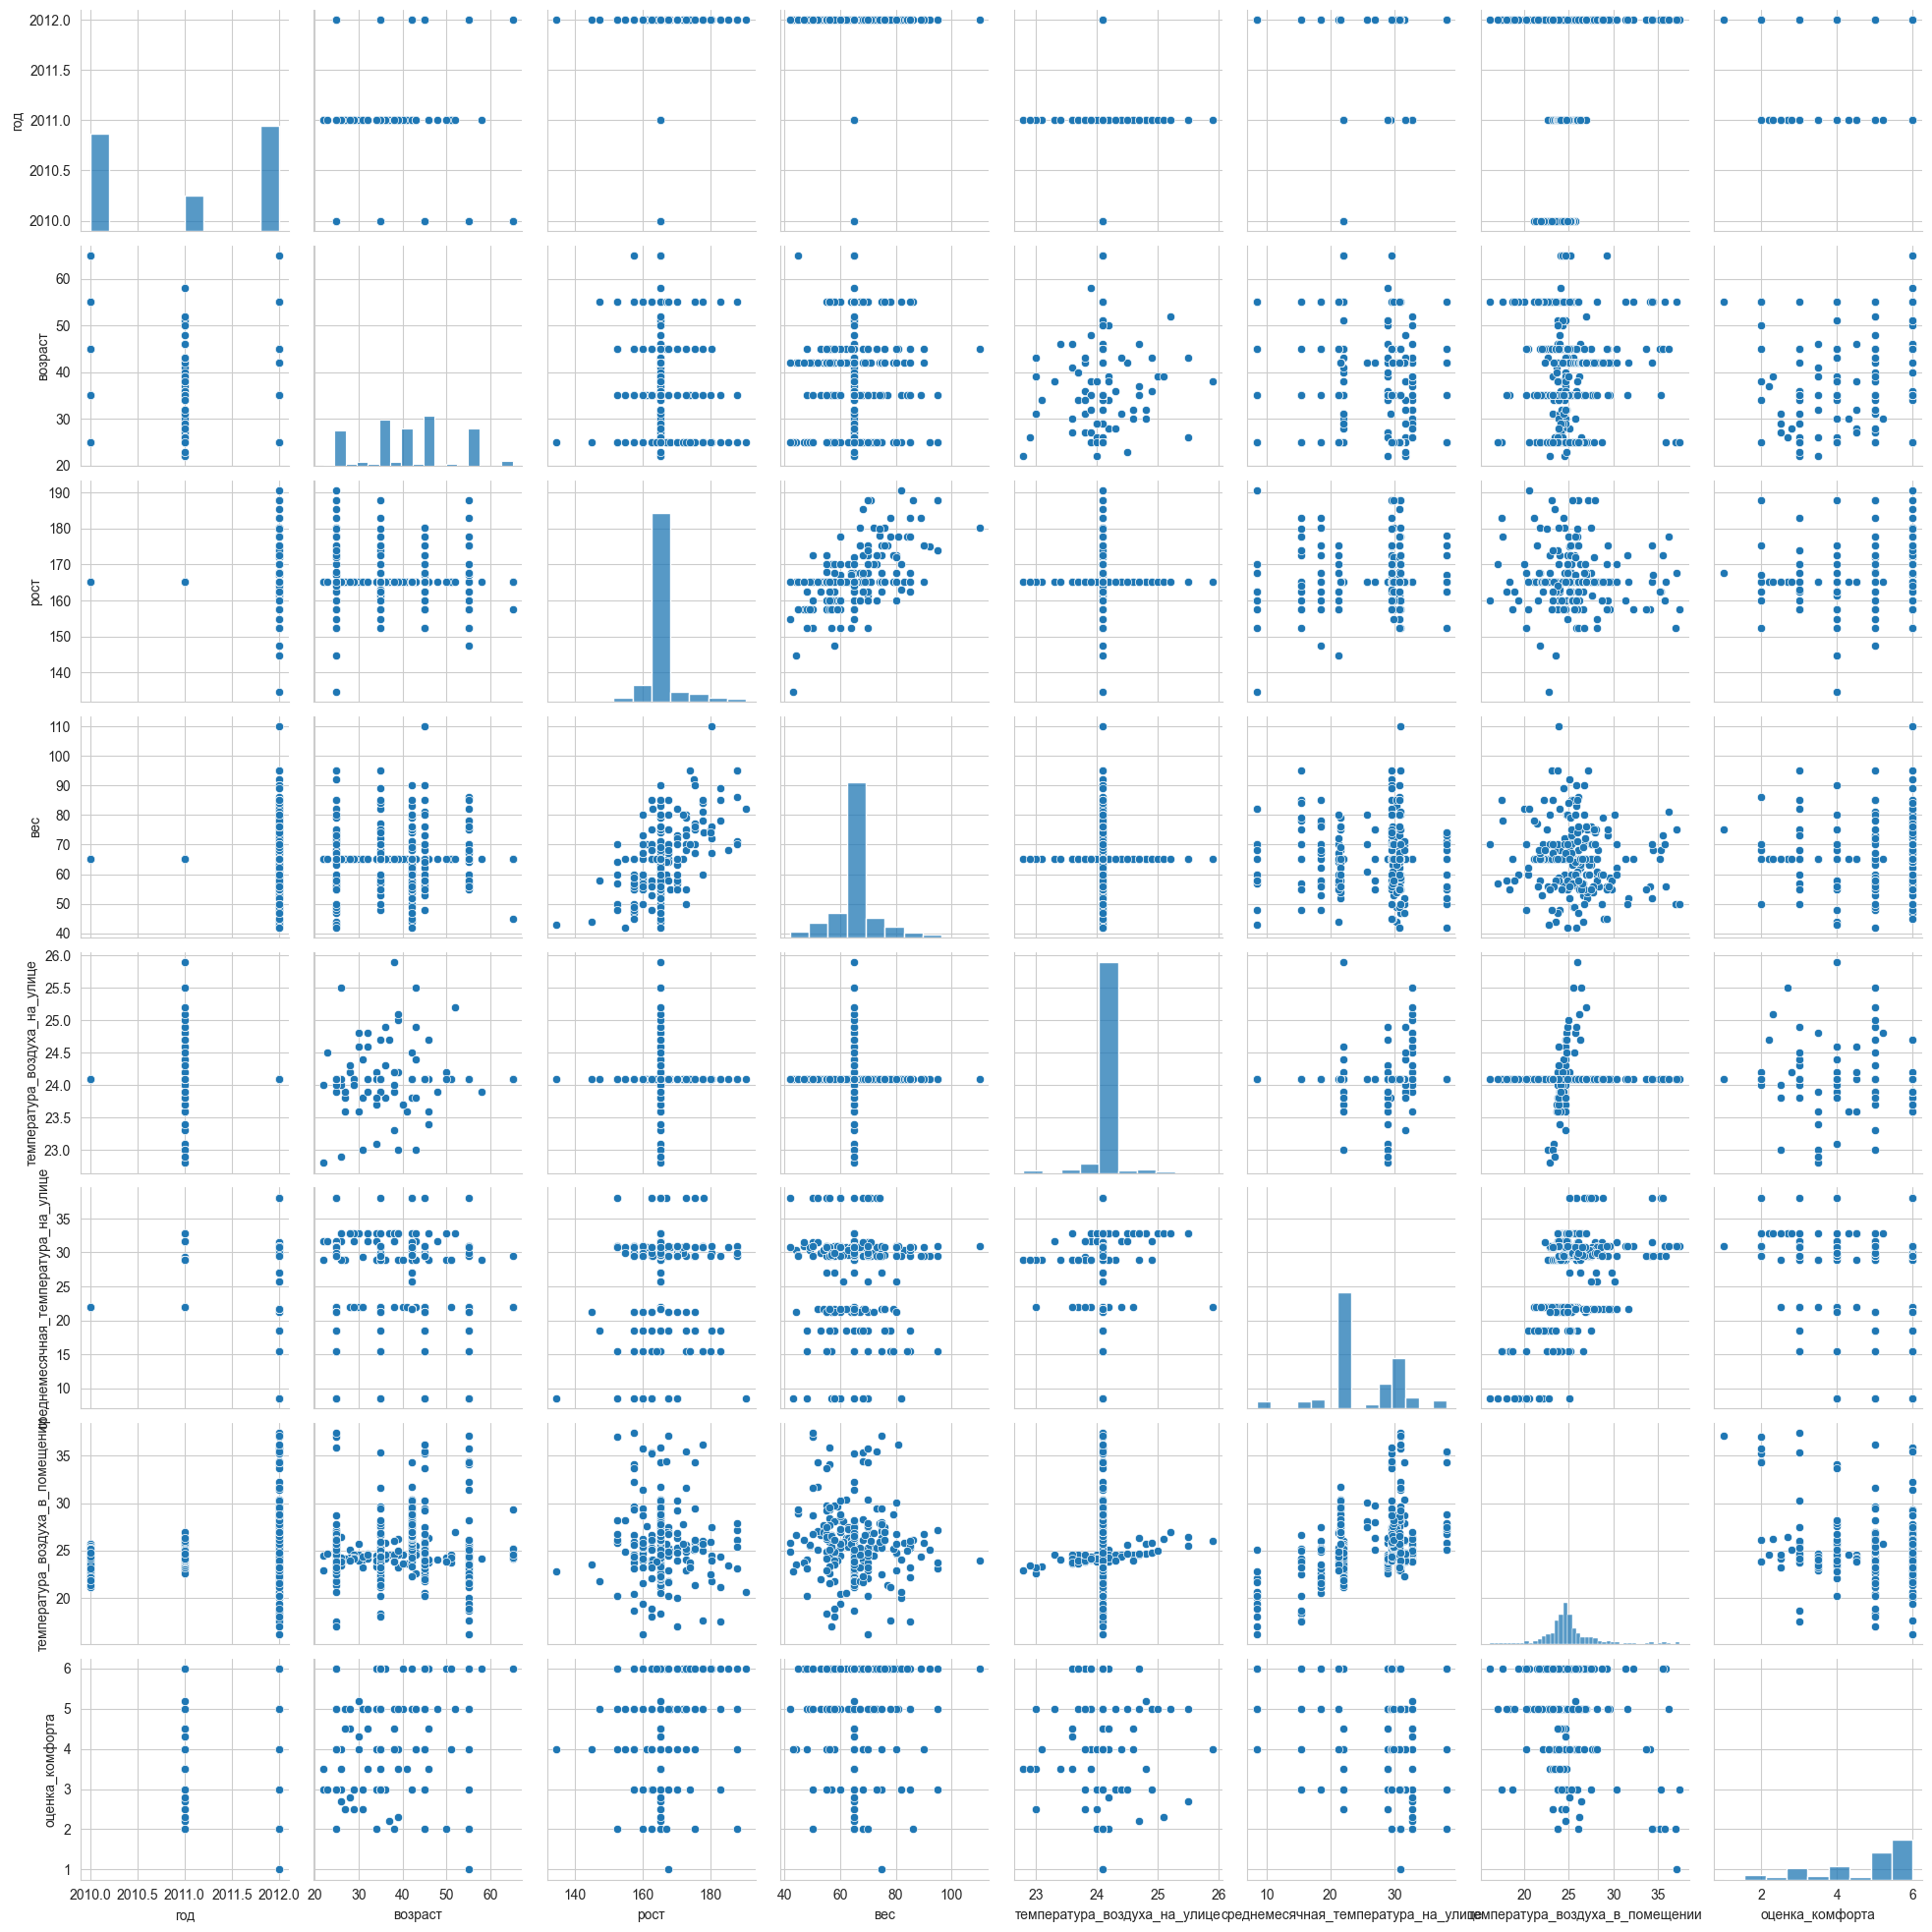

In [33]:
sns.pairplot(sub_df)

### Сохранение итогового датасета
Завершение 1 этапа и перехо ко 2 этапу работы

In [16]:
df.sort_values(["страна", "город", "год", "время_года", "способ_охлаждения", "режим_при_смешанном_типе_охлаждения", "пол", "оценка_комфорта"], inplace=True)
df.to_csv('data_2.csv', index=False, sep=';', encoding='utf-8')

## Заметки

1) Сильный ветер
https://en.wikipedia.org/wiki/List_of_tornadoes_in_the_2011_Super_Outbreak
https://ru.wikipedia.org/wiki/%D0%A1%D0%B5%D0%B7%D0%BE%D0%BD_%D0%B0%D1%82%D0%BB%D0%B0%D0%BD%D1%82%D0%B8%D1%87%D0%B5%D1%81%D0%BA%D0%B8%D1%85_%D1%83%D1%80%D0%B0%D0%B3%D0%B0%D0%BD%D0%BE%D0%B2
Везде где ветер в помещении выше 3 м/с это лето Техас 2011 год. В том году правда был ураган,
но судя по всему это явно выброс или просто пасхалка)

2) "температура_воздуха_в_помещении" > 40 (80-90)
Опять лето Техаса 2011, т.к. темп на улице примерно 25, то это выброс)

3) "среднемесячная_температура_на_улице" > 40 (80-90)
Не удивитесь лето Техаса 2011, т.к. темп на улице примерно 25, то это снова выброс)

4) Только в Индии есть времена года (не только лето) и только в Индии больше одного города

5) Города соответствуют странам (в городе только один тип климата)

6) Люди не имеют пола только... угадайте где в ТЕХАСЕ, там у всех 100% nan
Можно завести новый Техасский пол для этого случая)

7) Нету возраста только у людей из Индии конкретно (Хайдарабад, Ченнай)

8) Не желают расскрывать вес жители США и Австралии все 100%. Медиана похоже отпадает, либо признак теряет ценность.

9) С ростом к ним частично Индия подсоединяется, там больше пропусков

10) Утеплённость в среднем 0.46, 0.59, 0.80 по странам (США, Австралия, Индия)

11) По странам строк США=72 Австралия=198 Индия=214

12) способ_охлаждения => В США только Кондиционирование, в Австалии только Смешанный

13) **Посмотрел ещё раз датасет:
Аномально, что температура на улице 22-26 градусов всегда, а в офисе от 16 до 37. Словно должно быть ровно наоборот.
А среднемесячная от 8 до 38, хотя она средняя - разброс должен быть не такой большой как в моменте не улице.
Теперь кажется что сначала на улице и среднемесячную перепутали. А потом и офис с улицей перепутали. 
Т.к. в офисе малый разброс, среднемесячная средний разброс, и улица максимальный разброс должен быть.
Но это очень сильно больно плохо жёстко странно невыносимо если они правда колонки местами у всех напутали.**
